# Stage C: Final Modeling with Imbalance Handling (Baseline Models)

## 1️⃣ 목적
본 단계(Stage C)는 **Stability Selection (Top-40 Core Sensor Set)** 을 기반으로 불균형한 불량 데이터(Class 1)의 학습 성능을 개선하고, 다양한 불균형 처리 기법과 **기본 모델** 조합을 통해 베이스라인 성능을 확립하는 것을 목표로 합니다.

## 2️⃣ 실험 개요

| 항목 | 내용 |
|------|------|
| 입력 데이터 | `data/processed/base_master_median.parquet` |
| 피처 세트 | `core_features_top40.json` (Stability Selection 결과) |
| 타깃 변수 | label (0 = 정상, 1 = 불량) |
| 데이터 분할 | Train 80% / Test 20% (홀드아웃) |
| 스케일링 | RobustScaler() – 이상치 영향 완화용 |
| 불균형 처리 기법 | SMOTE / SMOTE+TomekLinks / Random Under-Sampling |
| 모델 후보군 | **Logistic Regression / Linear SVM / Decision Tree** |
| 평가지표(우선순위) | Recall → F1 → AUC-PR (보조: Precision, ROC AUC) |

## 3️⃣ 실험 구조
- **총 9개 조합**: 3개 불균형 기법 × 3개 기본 모델
- **평가 전략**: Recall 우선 → 불량 탐지 누락 최소화
- **목적**: 기본 모델로 베이스라인 성능 확립

## 4️⃣ 출력물
- `results/final/metrics_summary_baseline.csv` : 9개 조합 성능 비교표
- `models/best_baseline_model.pkl` : 최고 성능 기본 모델
- `models/scaler.pkl` : 학습된 스케일러

In [26]:
# ============================================================
# 🧩 Stage C 환경 세팅 (기본 모델 버전)
# ============================================================

import numpy as np
import pandas as pd
import json, pickle
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# ---------------- 데이터 처리 ----------------
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import RobustScaler

# ---------------- 불균형 처리 ----------------
from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.under_sampling import RandomUnderSampler

# ---------------- 기본 모델 ----------------
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.calibration import CalibratedClassifierCV  # LinearSVC 확률화용

# ---------------- 평가 지표 ----------------
from sklearn.metrics import (
    recall_score, precision_score, f1_score, 
    roc_auc_score, average_precision_score,
    confusion_matrix, classification_report
)

# ---------------- 시각화 ----------------
import matplotlib.pyplot as plt
import seaborn as sns

# ============================================================
# 📂 경로 설정 (노트북/스크립트 어디서 실행해도 동작)
# ============================================================
ROOT = Path.cwd().parent if Path.cwd().name == "notebooks" else Path.cwd()

DATA_MASTER = ROOT / 'data' / 'processed' / 'base_master_median.parquet'
CORE_FEATURES_PATH = ROOT / 'results' / 'stageC' / 'core_features_top40.json'

DIR_RESULTS = ROOT / 'results' / 'final'
DIR_MODELS  = ROOT / 'models'
DIR_FIGURES = DIR_RESULTS / 'figures'

for d in [DIR_RESULTS, DIR_MODELS, DIR_FIGURES]:
    d.mkdir(parents=True, exist_ok=True)

# ============================================================
# ⚙️ 재현성
# ============================================================
RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# ============================================================
# 🔎 사용 모델 안내
# - LogisticRegression: 확률 출력 O
# - LinearSVC: 기본은 확률 X → CalibratedClassifierCV로 래핑해서 확률/PR-AUC 가능
# - DecisionTreeClassifier: 확률 O
# ============================================================
print("✓ Stage C 환경 세팅 완료")
print(f"  - ROOT: {ROOT}")
print(f"  - 입력 데이터: {DATA_MASTER}")
print(f"  - Core Features: {CORE_FEATURES_PATH}")
print(f"  - 출력 디렉토리: {DIR_RESULTS}")
print(f"  - Random State: {RANDOM_STATE}")
print("\n📌 사용 모델: Logistic Regression, (Calibrated) Linear SVM, Decision Tree")

✓ Stage C 환경 세팅 완료
  - ROOT: /Users/mealkuo/Desktop/capstone02_project
  - 입력 데이터: /Users/mealkuo/Desktop/capstone02_project/data/processed/base_master_median.parquet
  - Core Features: /Users/mealkuo/Desktop/capstone02_project/results/stageC/core_features_top40.json
  - 출력 디렉토리: /Users/mealkuo/Desktop/capstone02_project/results/final
  - Random State: 42

📌 사용 모델: Logistic Regression, (Calibrated) Linear SVM, Decision Tree


## 데이터 준비

### 1단계: Stage A 마스터셋 재로드
- 스케일링 **적용 전** 버전 사용
- `base_master_median.parquet` 로드

### 2단계: Core Sensor Set 서브셋 구성
- Stage B에서 확정된 Top-40 Core Features만 선택
- 불필요한 피처 제거로 모델 복잡도 감소

In [27]:
# 데이터 로드 & Core Features 서브셋 구성
print("="*70)
print("데이터 로드 및 Core Features 서브셋 구성")
print("="*70)

# 1. Stage A 마스터셋 로드
df = pd.read_parquet(DATA_MASTER)
print(f"\n✓ 마스터셋 로드 완료")
print(f"  - Shape: {df.shape}")

# 2. Core Features 로드
with open(CORE_FEATURES_PATH, 'r') as f:
    core_features_info = json.load(f)

core_features = core_features_info['features']
print(f"\n✓ Core Features 로드 완료")
print(f"  - 피처 수: {len(core_features)}")
print(f"  - Stability Threshold: {core_features_info['stability_threshold']}/{core_features_info['n_folds']}")

# 3. 서브셋 구성
X_core = df[core_features].copy()
y = df['label'].copy()

print(f"\n✓ Core Feature 서브셋 구성 완료")
print(f"  - X shape: {X_core.shape}")
print(f"  - Feature 수: {X_core.shape[1]}")
print(f"  - Class distribution:")
print(y.value_counts())
print(f"  - Positive ratio: {y.mean():.4f}")

# 4. 기본 통계 확인
print(f"\n데이터 품질 체크:")
print(f"  - NaN 개수: {X_core.isnull().sum().sum()}")
print(f"  - Duplicate rows: {X_core.duplicated().sum()}")

데이터 로드 및 Core Features 서브셋 구성

✓ 마스터셋 로드 완료
  - Shape: (1567, 252)

✓ Core Features 로드 완료
  - 피처 수: 38
  - Stability Threshold: 3/5

✓ Core Feature 서브셋 구성 완료
  - X shape: (1567, 38)
  - Feature 수: 38
  - Class distribution:
label
0    1463
1     104
Name: count, dtype: int64
  - Positive ratio: 0.0664

데이터 품질 체크:
  - NaN 개수: 0
  - Duplicate rows: 0


## Train/Test 분리

### 전략
- **분할 비율**: Train 80% / Test 20%
- **Stratified Split**: 클래스 비율 유지
- **목적**: 
  - Train: 모델 학습 및 불균형 처리 적용
  - Test: 최종 성능 평가 (원본 분포 유지)

### ⚠️ 중요
Test 데이터는 **절대 샘플링하지 않음** → 실제 환경 시뮬레이션

In [28]:
# Train/Test 분리 (Stratified)
print("="*70)
print("Train/Test 분리")
print("="*70)

X_train, X_test, y_train, y_test = train_test_split(
    X_core, y, 
    test_size=0.2, 
    stratify=y, 
    random_state=RANDOM_STATE
)

print(f"\n✓ Train/Test 분리 완료")
print(f"\n[Train Set]")
print(f"  - Shape: {X_train.shape}")
print(f"  - Class distribution:\n{y_train.value_counts()}")
print(f"  - Positive ratio: {y_train.mean():.4f}")

print(f"\n[Test Set]")
print(f"  - Shape: {X_test.shape}")
print(f"  - Class distribution:\n{y_test.value_counts()}")
print(f"  - Positive ratio: {y_test.mean():.4f}")

# 인덱스 리셋
X_train = X_train.reset_index(drop=True)
X_test = X_test.reset_index(drop=True)
y_train = y_train.reset_index(drop=True)
y_test = y_test.reset_index(drop=True)

print(f"\n✓ 인덱스 리셋 완료")

Train/Test 분리

✓ Train/Test 분리 완료

[Train Set]
  - Shape: (1253, 38)
  - Class distribution:
label
0    1170
1      83
Name: count, dtype: int64
  - Positive ratio: 0.0662

[Test Set]
  - Shape: (314, 38)
  - Class distribution:
label
0    293
1     21
Name: count, dtype: int64
  - Positive ratio: 0.0669

✓ 인덱스 리셋 완료


## 스케일링

### RobustScaler 선택 이유
- 이상치에 강건한 스케일링
- Median과 IQR 기반 변환
- SECOM 데이터의 센서 값 특성에 적합

### ⚠️ 특히 중요한 이유
**Logistic Regression과 Linear SVM은 스케일에 민감**합니다!
- 피처 간 스케일이 다르면 학습이 제대로 되지 않음
- Decision Tree는 스케일 불변이지만, 일관성을 위해 모두 적용

### 적용 순서
1. Train 데이터로 **fit**
2. Train과 Test 모두 **transform**
3. 샘플링은 스케일링 **이후** 적용

In [29]:
# RobustScaler 적용
print("="*70)
print("RobustScaler 적용")
print("="*70)

# Scaler 생성 및 학습 (Train만)
scaler = RobustScaler()
scaler.fit(X_train)

# Transform (Train + Test)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# DataFrame 변환 (컬럼명 유지)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print(f"\n✓ RobustScaler 적용 완료")
print(f"  - Scaler fit on Train: {X_train.shape}")
print(f"  - Train scaled: {X_train_scaled.shape}")
print(f"  - Test scaled: {X_test_scaled.shape}")

# 스케일링 전후 비교 (첫 번째 피처)
feat = X_train.columns[0]
print(f"\n스케일링 효과 확인 (예시: {feat}):")
print(f"  [Before] Mean={X_train[feat].mean():.3f}, Std={X_train[feat].std():.3f}")
print(f"  [After]  Mean={X_train_scaled[feat].mean():.3f}, Std={X_train_scaled[feat].std():.3f}")

print(f"\n💡 Linear 모델(LogReg, SVM)은 스케일링 필수!")

RobustScaler 적용

✓ RobustScaler 적용 완료
  - Scaler fit on Train: (1253, 38)
  - Train scaled: (1253, 38)
  - Test scaled: (314, 38)

스케일링 효과 확인 (예시: sensor_065):
  [Before] Mean=20.213, Std=4.410
  [After]  Mean=0.042, Std=0.842

💡 Linear 모델(LogReg, SVM)은 스케일링 필수!


## 불균형 처리 전략

### 3가지 기법 비교

| 기법 | 유형 | 설명 | 기대 효과 |
|------|------|------|----------|
| **SMOTE** | 오버샘플링 | 소수 클래스 간 합성 샘플 생성 | Recall 향상 |
| **SMOTE + TomekLinks** | 하이브리드 | SMOTE 후 경계 노이즈 제거 | Precision 유지 + 균형적 성능 |
| **RUS** | 언더샘플링 | 다수 클래스 무작위 제거 | 과적합 완화 + 학습속도 개선 |

### ⚠️ 핵심 원칙
- 샘플링은 **Train 데이터에만** 적용
- Test 데이터는 **원본 분포 유지** (실제 환경 반영)

In [30]:
# 불균형 처리 함수
def apply_sampling(X_train, y_train, method, random_state=42):
    """
    불균형 처리 적용 함수
    
    Parameters:
    -----------
    X_train : DataFrame
        학습 데이터
    y_train : Series
        학습 레이블
    method : str
        'SMOTE', 'SMOTE+Tomek', 'RUS' 중 선택
    
    Returns:
    --------
    X_resampled, y_resampled : 샘플링된 데이터
    """
    
    if method == 'SMOTE':
        sampler = SMOTE(random_state=random_state)
    elif method == 'SMOTE+Tomek':
        sampler = SMOTETomek(random_state=random_state)
    elif method == 'RUS':
        sampler = RandomUnderSampler(random_state=random_state)
    else:
        raise ValueError(f"Unknown sampling method: {method}")
    
    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    
    print(f"  [{method}]")
    print(f"    Before: {len(y_train)} samples, Pos ratio: {y_train.mean():.4f}")
    print(f"    After:  {len(y_resampled)} samples, Pos ratio: {y_resampled.mean():.4f}")
    
    return X_resampled, y_resampled

# 테스트
print("="*70)
print("불균형 처리 함수 테스트")
print("="*70)
print()

for method in ['SMOTE', 'SMOTE+Tomek', 'RUS']:
    X_temp, y_temp = apply_sampling(X_train_scaled, y_train, method)
    print()

불균형 처리 함수 테스트

  [SMOTE]
    Before: 1253 samples, Pos ratio: 0.0662
    After:  2340 samples, Pos ratio: 0.5000

  [SMOTE+Tomek]
    Before: 1253 samples, Pos ratio: 0.0662
    After:  2340 samples, Pos ratio: 0.5000

  [RUS]
    Before: 1253 samples, Pos ratio: 0.0662
    After:  166 samples, Pos ratio: 0.5000



## 기본 모델 학습 및 비교

### 실험 매트릭스
**3개 불균형 기법 × 3개 기본 모델 = 총 9개 조합**

| Core Set | Sampling | Model | Recall | F1 | AUC-PR |
|----------|----------|-------|--------|----|----|
| Top-40 | SMOTE | Logistic Regression | - | - | - |
| Top-40 | SMOTE | Linear SVM | - | - | - |
| Top-40 | SMOTE | Decision Tree | - | - | - |
| Top-40 | SMOTE+Tomek | Logistic Regression | - | - | - |
| ... | ... | ... | ... | ... | ... |

### 기본 모델 설정

| 모델 | 핵심 파라미터 | 특징 |
|------|-------------|------|
| **Logistic Regression** | max_iter=1000, class_weight='None' | 선형 분류기, 확률 추정 가능 |
| **Linear SVM** | max_iter=1000, class_weight='None' | 마진 최대화, 선형 결정 경계 |
| **Decision Tree** | max_depth=10, class_weight='None' | 비선형, 해석 가능 |

### 평가 지표 우선순위
1. **Recall** (최우선) - 불량 탐지 누락 최소화
2. **F1-Score** - 균형적 성능
3. **AUC-PR** - 불균형 데이터에 적합한 지표

### 📌 목적
기본 모델로 **베이스라인 성능**을 확립하여, 향후 고급 모델(RF, XGBoost 등)과 비교 기준점 마련

In [31]:
# 모델 학습 루프
print("="*70)
print("기본 모델 학습 시작: 9개 조합 (3 Sampling × 3 Models)")
print("="*70)

# 샘플링 기법 리스트
sampling_methods = ['SMOTE', 'SMOTE+Tomek', 'RUS']

# 모델 정의 함수
def get_model(model_name, random_state=42):
    """기본 모델 생성 함수"""
    
    if model_name == 'LogisticRegression':
        return LogisticRegression(
            max_iter=1000,
            class_weight= None,
            random_state=random_state,
            n_jobs=-1
        )
    
    elif model_name == 'LinearSVM':
        return LinearSVC(
            max_iter=1000,
            class_weight= None,
            random_state=random_state,
            dual=False  # n_samples > n_features인 경우 더 빠름
        )
    
    elif model_name == 'DecisionTree':
        return DecisionTreeClassifier(
            max_depth=10,
            class_weight= None,
            random_state=random_state
        )
    
    else:
        raise ValueError(f"Unknown model: {model_name}")

# 모델 리스트
model_names = ['LogisticRegression', 'LinearSVM', 'DecisionTree']

# 결과 저장 리스트
results = []
trained_models = {}

# 학습 루프
for sampling_method in sampling_methods:
    print(f"\n{'='*70}")
    print(f"Sampling Method: {sampling_method}")
    print(f"{'='*70}")
    
    # 샘플링 적용
    X_train_resampled, y_train_resampled = apply_sampling(
        X_train_scaled, y_train, sampling_method, RANDOM_STATE
    )
    
    for model_name in model_names:
        print(f"\n  --- Model: {model_name} ---")
        
        # 모델 생성
        model = get_model(model_name, RANDOM_STATE)
        
        # 학습
        model.fit(X_train_resampled, y_train_resampled)
        print(f"    ✓ 학습 완료")
        
        # 예측
        y_pred = model.predict(X_test_scaled)
        
        # LinearSVM은 decision_function 사용 (predict_proba 없음)
        if model_name == 'LinearSVM':
            y_score = model.decision_function(X_test_scaled)
        else:
            y_proba = model.predict_proba(X_test_scaled)[:, 1]
            y_score = y_proba
        
        # 평가
        recall = recall_score(y_test, y_pred)
        precision = precision_score(y_test, y_pred)
        f1 = f1_score(y_test, y_pred)
        roc_auc = roc_auc_score(y_test, y_score)
        auc_pr = average_precision_score(y_test, y_score)
        
        # 결과 출력
        print(f"    Recall:    {recall:.4f}")
        print(f"    Precision: {precision:.4f}")
        print(f"    F1-Score:  {f1:.4f}")
        print(f"    ROC-AUC:   {roc_auc:.4f}")
        print(f"    AUC-PR:    {auc_pr:.4f}")
        
        # 결과 저장
        result = {
            'Core_Set': 'Top-40',
            'Sampling': sampling_method,
            'Model': model_name,
            'Recall': recall,
            'Precision': precision,
            'F1': f1,
            'ROC_AUC': roc_auc,
            'AUC_PR': auc_pr
        }
        results.append(result)
        
        # 모델 저장 (나중에 최고 성능 선택용)
        key = f"{sampling_method}_{model_name}"
        trained_models[key] = {
            'model': model,
            'metrics': result
        }

print(f"\n{'='*70}")
print("✓ 모든 조합 학습 완료")
print(f"{'='*70}")

기본 모델 학습 시작: 9개 조합 (3 Sampling × 3 Models)

Sampling Method: SMOTE
  [SMOTE]
    Before: 1253 samples, Pos ratio: 0.0662
    After:  2340 samples, Pos ratio: 0.5000

  --- Model: LogisticRegression ---
    ✓ 학습 완료
    Recall:    0.5714
    Precision: 0.1395
    F1-Score:  0.2243
    ROC-AUC:   0.6587
    AUC-PR:    0.1677

  --- Model: LinearSVM ---
    ✓ 학습 완료
    Recall:    0.5714
    Precision: 0.1364
    F1-Score:  0.2202
    ROC-AUC:   0.6649
    AUC-PR:    0.1686

  --- Model: DecisionTree ---
    ✓ 학습 완료
    Recall:    0.1905
    Precision: 0.0714
    F1-Score:  0.1039
    ROC-AUC:   0.5448
    AUC-PR:    0.0808

Sampling Method: SMOTE+Tomek
  [SMOTE+Tomek]
    Before: 1253 samples, Pos ratio: 0.0662
    After:  2340 samples, Pos ratio: 0.5000

  --- Model: LogisticRegression ---
    ✓ 학습 완료
    Recall:    0.5714
    Precision: 0.1395
    F1-Score:  0.2243
    ROC-AUC:   0.6587
    AUC-PR:    0.1677

  --- Model: LinearSVM ---
    ✓ 학습 완료
    Recall:    0.5714
    Precision: 0.1

In [32]:
# 결과 DataFrame 생성
results_df = pd.DataFrame(results)

# 정렬 (Recall 우선, F1 차선, AUC-PR 차차선)
results_df = results_df.sort_values(
    by=['Recall', 'F1', 'AUC_PR'], 
    ascending=False
).reset_index(drop=True)

print("="*70)
print("전체 결과 요약 (기본 모델)")
print("="*70)
print(results_df.to_string(index=False))

# CSV 저장
output_csv = DIR_RESULTS / 'metrics_summary_baseline.csv'
results_df.to_csv(output_csv, index=False)
print(f"\n✓ 결과 저장: {output_csv}")

# 최고 성능 조합 추출
best_result = results_df.iloc[0]
print(f"\n{'='*70}")
print("🏆 최고 성능 조합 (Baseline Models)")
print(f"{'='*70}")
print(f"  Sampling: {best_result['Sampling']}")
print(f"  Model:    {best_result['Model']}")
print(f"  Recall:   {best_result['Recall']:.4f}")
print(f"  F1:       {best_result['F1']:.4f}")
print(f"  AUC-PR:   {best_result['AUC_PR']:.4f}")
print(f"  Precision: {best_result['Precision']:.4f}")
print(f"  ROC-AUC:  {best_result['ROC_AUC']:.4f}")

전체 결과 요약 (기본 모델)
Core_Set    Sampling              Model   Recall  Precision       F1  ROC_AUC   AUC_PR
  Top-40         RUS       DecisionTree 0.666667   0.106061 0.183007 0.631968 0.093000
  Top-40         RUS LogisticRegression 0.619048   0.121495 0.203125 0.673980 0.140253
  Top-40       SMOTE LogisticRegression 0.571429   0.139535 0.224299 0.658703 0.167723
  Top-40 SMOTE+Tomek LogisticRegression 0.571429   0.139535 0.224299 0.658703 0.167723
  Top-40       SMOTE          LinearSVM 0.571429   0.136364 0.220183 0.664879 0.168596
  Top-40 SMOTE+Tomek          LinearSVM 0.571429   0.136364 0.220183 0.664879 0.168596
  Top-40         RUS          LinearSVM 0.571429   0.112150 0.187500 0.665204 0.125978
  Top-40       SMOTE       DecisionTree 0.190476   0.071429 0.103896 0.544775 0.080839
  Top-40 SMOTE+Tomek       DecisionTree 0.190476   0.071429 0.103896 0.544775 0.080839

✓ 결과 저장: /Users/mealkuo/Desktop/capstone02_project/results/final/metrics_summary_baseline.csv

🏆 최고 성능 조합 (Basel

## 결과 시각화

기본 모델의 성능을 시각화하여 베이스라인을 확립합니다:
1. **성능 비교 히트맵** - 9개 조합의 Recall/F1/AUC-PR 한눈에
2. **Sampling 기법별 비교** - 박스플롯
3. **모델별 성능 비교** - 바차트
4. **Confusion Matrix** - 최고 성능 모델
5. **모델 간 성능 비교 레이더 차트**

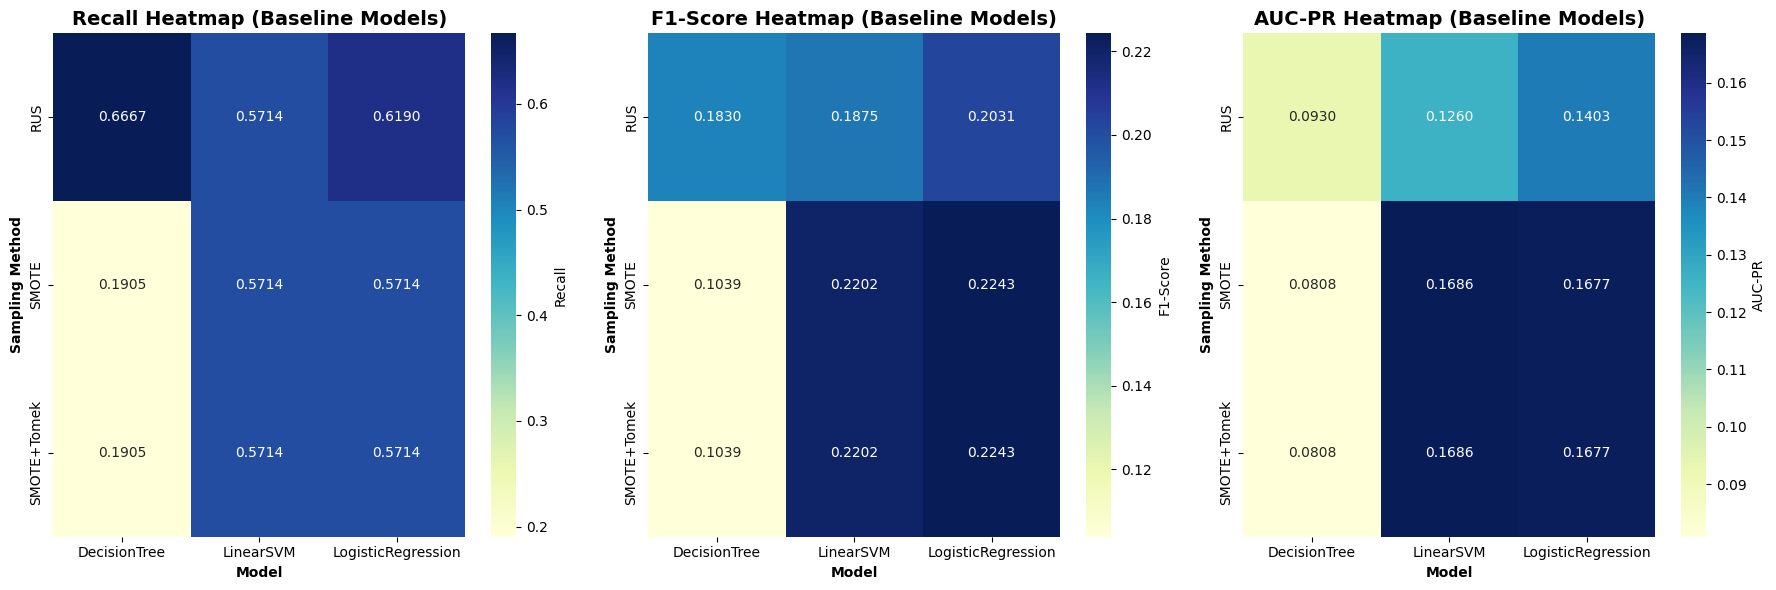

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/final/figures/01_baseline_performance_heatmap.png


In [33]:
# 시각화 1: 성능 히트맵
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

metrics_to_plot = ['Recall', 'F1', 'AUC_PR']
metric_names = ['Recall', 'F1-Score', 'AUC-PR']

for idx, (metric, name) in enumerate(zip(metrics_to_plot, metric_names)):
    # 피벗 테이블 생성
    pivot = results_df.pivot(index='Sampling', columns='Model', values=metric)
    
    # 히트맵
    sns.heatmap(pivot, annot=True, fmt='.4f', cmap='YlGnBu', 
                cbar_kws={'label': name}, ax=axes[idx],
                vmin=pivot.min().min(), vmax=pivot.max().max())
    
    axes[idx].set_title(f'{name} Heatmap (Baseline Models)', fontsize=14, fontweight='bold')
    axes[idx].set_xlabel('Model', fontweight='bold')
    axes[idx].set_ylabel('Sampling Method', fontweight='bold')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '01_baseline_performance_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '01_baseline_performance_heatmap.png'}")

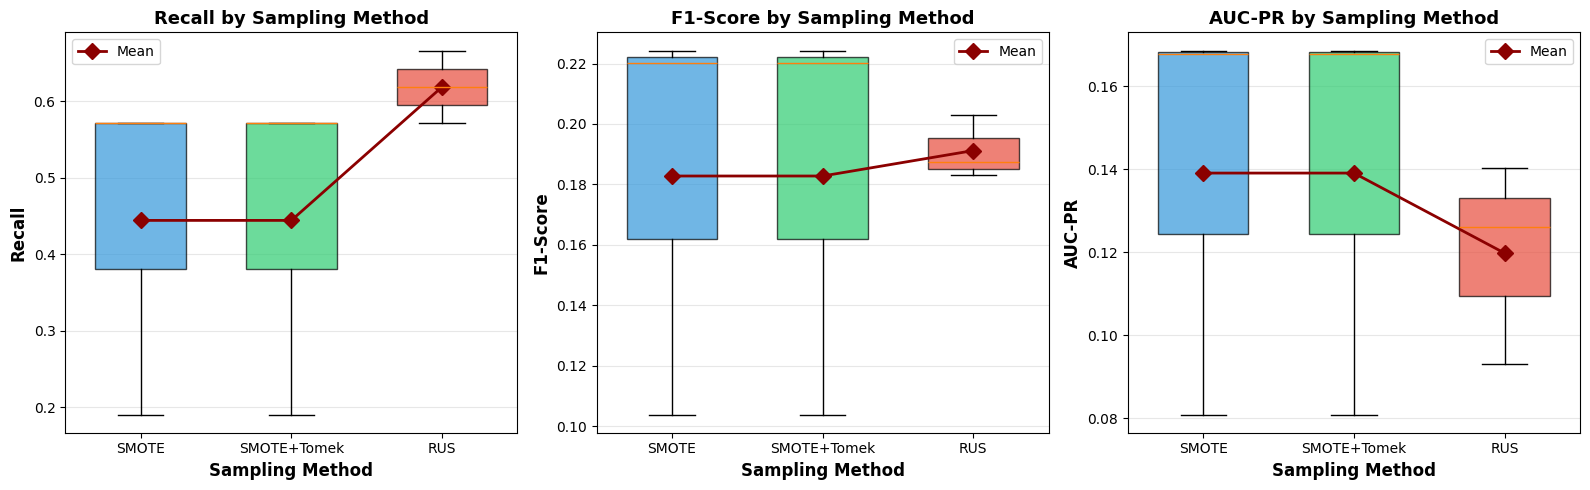

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/final/figures/02_baseline_sampling_comparison.png


In [34]:
# 시각화 2: Sampling 기법별 성능 비교
fig, axes = plt.subplots(1, 3, figsize=(16, 5))

metrics = ['Recall', 'F1', 'AUC_PR']
metric_names = ['Recall', 'F1-Score', 'AUC-PR']
colors = ['#3498db', '#2ecc71', '#e74c3c']

for idx, (metric, name) in enumerate(zip(metrics, metric_names)):
    # Sampling 기법별 데이터
    data_by_sampling = [results_df[results_df['Sampling'] == s][metric].values 
                        for s in sampling_methods]
    
    # 박스플롯
    bp = axes[idx].boxplot(data_by_sampling, labels=sampling_methods, 
                           patch_artist=True, widths=0.6)
    
    # 색상 적용
    for patch, color in zip(bp['boxes'], colors):
        patch.set_facecolor(color)
        patch.set_alpha(0.7)
    
    axes[idx].set_ylabel(name, fontweight='bold', fontsize=12)
    axes[idx].set_xlabel('Sampling Method', fontweight='bold', fontsize=12)
    axes[idx].set_title(f'{name} by Sampling Method', fontweight='bold', fontsize=13)
    axes[idx].grid(axis='y', alpha=0.3)
    
    # 평균선 표시
    means = [results_df[results_df['Sampling'] == s][metric].mean() 
             for s in sampling_methods]
    axes[idx].plot(range(1, len(sampling_methods)+1), means, 'D-', 
                   color='darkred', linewidth=2, markersize=8, label='Mean')
    axes[idx].legend()

plt.tight_layout()
plt.savefig(DIR_FIGURES / '02_baseline_sampling_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '02_baseline_sampling_comparison.png'}")

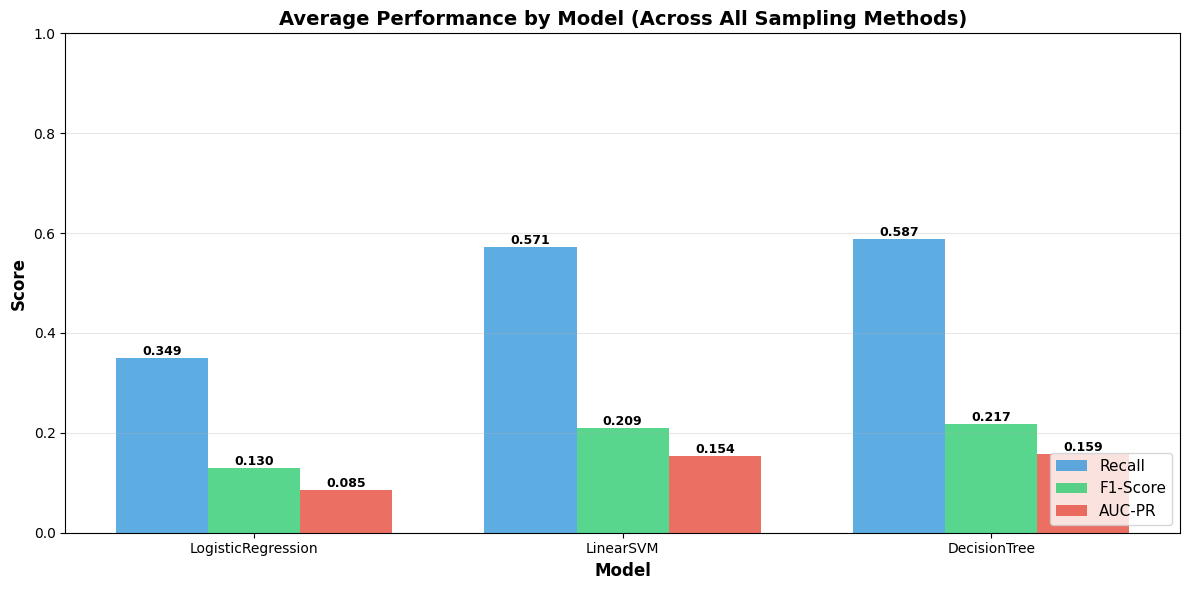

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/final/figures/03_baseline_model_comparison.png


In [35]:
# 시각화 3: 모델별 평균 성능
fig, ax = plt.subplots(figsize=(12, 6))

# 모델별 평균 계산
model_avg = results_df.groupby('Model')[['Recall', 'F1', 'AUC_PR']].mean()

# 바차트
x = np.arange(len(model_names))
width = 0.25

bars1 = ax.bar(x - width, model_avg['Recall'], width, label='Recall', 
               alpha=0.8, color='#3498db')
bars2 = ax.bar(x, model_avg['F1'], width, label='F1-Score', 
               alpha=0.8, color='#2ecc71')
bars3 = ax.bar(x + width, model_avg['AUC_PR'], width, label='AUC-PR', 
               alpha=0.8, color='#e74c3c')

# 값 표시
for bars in [bars1, bars2, bars3]:
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=9, fontweight='bold')

ax.set_xlabel('Model', fontweight='bold', fontsize=12)
ax.set_ylabel('Score', fontweight='bold', fontsize=12)
ax.set_title('Average Performance by Model (Across All Sampling Methods)', 
             fontweight='bold', fontsize=14)
ax.set_xticks(x)
ax.set_xticklabels(model_names)
ax.legend(loc='lower right', fontsize=11)
ax.set_ylim([0, 1.0])
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '03_baseline_model_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '03_baseline_model_comparison.png'}")

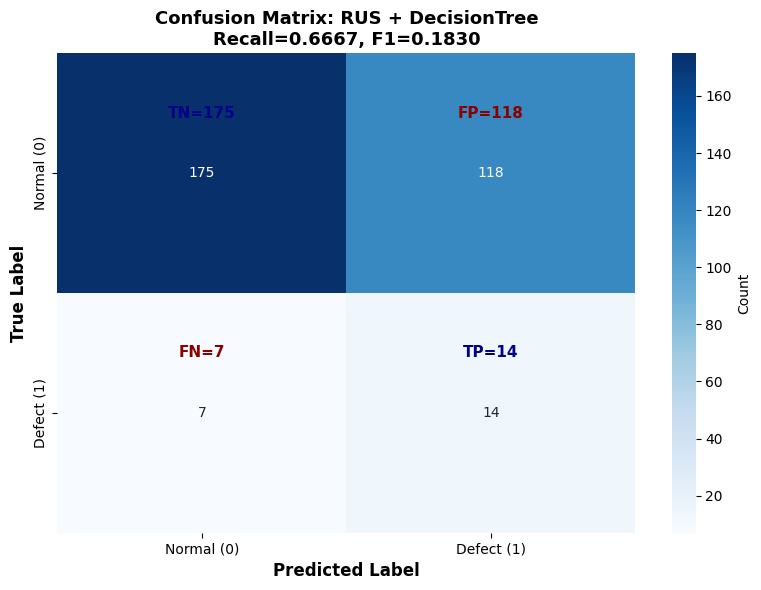

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/final/figures/04_baseline_confusion_matrix_best.png

Classification Report: RUS + DecisionTree
              precision    recall  f1-score   support

      Normal       0.96      0.60      0.74       293
      Defect       0.11      0.67      0.18        21

    accuracy                           0.60       314
   macro avg       0.53      0.63      0.46       314
weighted avg       0.90      0.60      0.70       314



In [36]:
# 시각화 4: 최고 성능 모델의 Confusion Matrix
best_key = f"{best_result['Sampling']}_{best_result['Model']}"
best_model = trained_models[best_key]['model']

# 예측
y_pred_best = best_model.predict(X_test_scaled)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred_best)

# 플롯
fig, ax = plt.subplots(figsize=(8, 6))

sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Normal (0)', 'Defect (1)'],
            yticklabels=['Normal (0)', 'Defect (1)'],
            cbar_kws={'label': 'Count'},
            ax=ax)

ax.set_xlabel('Predicted Label', fontweight='bold', fontsize=12)
ax.set_ylabel('True Label', fontweight='bold', fontsize=12)
ax.set_title(f'Confusion Matrix: {best_result["Sampling"]} + {best_result["Model"]}\n' + 
             f'Recall={best_result["Recall"]:.4f}, F1={best_result["F1"]:.4f}',
             fontweight='bold', fontsize=13)

# TN, FP, FN, TP 레이블
ax.text(0.5, 0.25, f'TN={cm[0,0]}', ha='center', va='center', fontsize=11, color='darkblue', fontweight='bold')
ax.text(1.5, 0.25, f'FP={cm[0,1]}', ha='center', va='center', fontsize=11, color='darkred', fontweight='bold')
ax.text(0.5, 1.25, f'FN={cm[1,0]}', ha='center', va='center', fontsize=11, color='darkred', fontweight='bold')
ax.text(1.5, 1.25, f'TP={cm[1,1]}', ha='center', va='center', fontsize=11, color='darkblue', fontweight='bold')

plt.tight_layout()
plt.savefig(DIR_FIGURES / '04_baseline_confusion_matrix_best.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '04_baseline_confusion_matrix_best.png'}")

# Classification Report
print(f"\n{'='*70}")
print(f"Classification Report: {best_result['Sampling']} + {best_result['Model']}")
print(f"{'='*70}")
print(classification_report(y_test, y_pred_best, target_names=['Normal', 'Defect']))

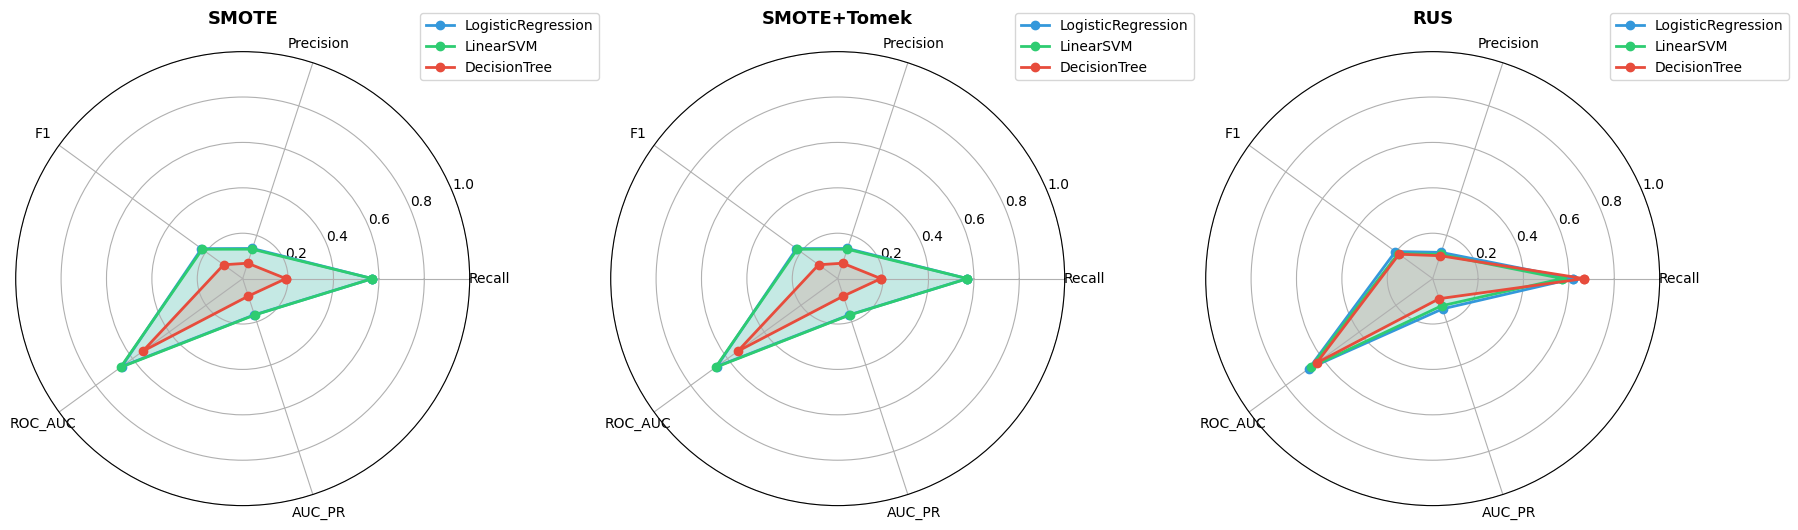

✓ 저장: /Users/mealkuo/Desktop/capstone02_project/results/final/figures/05_baseline_radar_chart.png


In [37]:
# 시각화 5: 모델 간 성능 레이더 차트
from math import pi

fig, axes = plt.subplots(1, 3, figsize=(18, 6), subplot_kw=dict(projection='polar'))

# 각 샘플링 기법별로 레이더 차트
for idx, sampling in enumerate(sampling_methods):
    ax = axes[idx]
    
    # 해당 샘플링의 모델별 데이터
    sampling_data = results_df[results_df['Sampling'] == sampling]
    
    # 메트릭과 각도 설정
    categories = ['Recall', 'Precision', 'F1', 'ROC_AUC', 'AUC_PR']
    N = len(categories)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # 각 모델별로 플롯
    colors_radar = ['#3498db', '#2ecc71', '#e74c3c']
    for model, color in zip(model_names, colors_radar):
        model_data = sampling_data[sampling_data['Model'] == model].iloc[0]
        values = [model_data[cat] for cat in categories]
        values += values[:1]
        
        ax.plot(angles, values, 'o-', linewidth=2, label=model, color=color)
        ax.fill(angles, values, alpha=0.15, color=color)
    
    # 설정
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories, fontsize=10)
    ax.set_ylim(0, 1)
    ax.set_title(f'{sampling}', fontweight='bold', fontsize=13, pad=20)
    ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1))
    ax.grid(True)

plt.tight_layout()
plt.savefig(DIR_FIGURES / '05_baseline_radar_chart.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"✓ 저장: {DIR_FIGURES / '05_baseline_radar_chart.png'}")

## 최종 베이스라인 모델 저장

배포 가능한 형태로 최고 성능 기본 모델과 스케일러를 저장합니다.

**저장 파일**:
1. `best_baseline_model.pkl` : 최고 성능 기본 모델
2. `scaler.pkl` : RobustScaler (학습된 상태)
3. `baseline_model_info.json` : 모델 메타정보

향후 고급 모델(RF, XGBoost 등)과 성능 비교의 기준점이 됩니다.

In [38]:
# 최종 베이스라인 모델 저장
print("="*70)
print("최종 베이스라인 모델 저장")
print("="*70)

# 1. 최고 성능 모델 저장
best_model_path = DIR_MODELS / 'best_baseline_model.pkl'
with open(best_model_path, 'wb') as f:
    pickle.dump(best_model, f)
print(f"✓ 최고 성능 베이스라인 모델 저장: {best_model_path}")

# 2. Scaler 저장
scaler_path = DIR_MODELS / 'scaler.pkl'
with open(scaler_path, 'wb') as f:
    pickle.dump(scaler, f)
print(f"✓ Scaler 저장: {scaler_path}")

# 3. 모델 정보 저장
model_info = {
    'model_type': 'baseline',
    'best_combination': {
        'sampling_method': best_result['Sampling'],
        'model_name': best_result['Model'],
        'core_features': core_features,
        'n_features': len(core_features)
    },
    'performance': {
        'recall': float(best_result['Recall']),
        'precision': float(best_result['Precision']),
        'f1': float(best_result['F1']),
        'roc_auc': float(best_result['ROC_AUC']),
        'auc_pr': float(best_result['AUC_PR'])
    },
    'training_info': {
        'train_size': int(len(X_train)),
        'test_size': int(len(X_test)),
        'random_state': RANDOM_STATE,
        'scaler': 'RobustScaler'
    },
    'model_description': {
        'LogisticRegression': 'Linear model with probabilistic output',
        'LinearSVM': 'Maximum margin classifier with linear boundary',
        'DecisionTree': 'Non-linear, interpretable tree-based model'
    }
}

model_info_path = DIR_MODELS / 'baseline_model_info.json'
with open(model_info_path, 'w') as f:
    json.dump(model_info, f, indent=2)
print(f"✓ 모델 정보 저장: {model_info_path}")

print(f"\n{'='*70}")
print("✓ 모든 산출물 저장 완료")
print(f"{'='*70}")

최종 베이스라인 모델 저장
✓ 최고 성능 베이스라인 모델 저장: /Users/mealkuo/Desktop/capstone02_project/models/best_baseline_model.pkl
✓ Scaler 저장: /Users/mealkuo/Desktop/capstone02_project/models/scaler.pkl
✓ 모델 정보 저장: /Users/mealkuo/Desktop/capstone02_project/models/baseline_model_info.json

✓ 모든 산출물 저장 완료


In [39]:
# 추론 예제 코드 생성 (배포용)
inference_code = f'''
# 베이스라인 모델 로드 및 추론 예제 코드
import pickle
import pandas as pd
import numpy as np

# 1. 모델 및 스케일러 로드
with open('models/best_baseline_model.pkl', 'rb') as f:
    model = pickle.load(f)

with open('models/scaler.pkl', 'rb') as f:
    scaler = pickle.load(f)

print(f"✓ 모델 로드 완료: {best_result['Model']}")
print(f"✓ Sampling 기법: {best_result['Sampling']}")

# 2. Core Features (순서 중요!)
core_features = {core_features}

# 3. 새로운 데이터 로드 (예시)
# new_data = pd.read_csv('new_sensor_data.csv')
# X_new = new_data[core_features]

# 4. 스케일링
# X_new_scaled = scaler.transform(X_new)

# 5. 예측
# y_pred = model.predict(X_new_scaled)  # 0 or 1

# LinearSVM의 경우 decision_function 사용 가능
# if hasattr(model, 'decision_function'):
#     y_score = model.decision_function(X_new_scaled)
# else:
#     y_proba = model.predict_proba(X_new_scaled)[:, 1]
#     y_score = y_proba

# 6. 결과 해석
# defect_indices = [i for i, pred in enumerate(y_pred) if pred == 1]
# print(f"불량 탐지: {{len(defect_indices)}}건")
# print(f"불량 비율: {{len(defect_indices)/len(y_pred)*100:.2f}}%")

# 7. 예측 결과 저장
# result_df = pd.DataFrame({{
#     'prediction': y_pred,
#     'score': y_score
# }})
# result_df.to_csv('prediction_results.csv', index=False)
'''

# 파일로 저장
inference_example_path = DIR_MODELS / 'baseline_inference_example.py'
with open(inference_example_path, 'w') as f:
    f.write(inference_code)

print(f"✓ 추론 예제 코드 저장: {inference_example_path}")

✓ 추론 예제 코드 저장: /Users/mealkuo/Desktop/capstone02_project/models/baseline_inference_example.py


In [40]:
# 최종 요약 및 인사이트
print("\n" + "="*70)
print("Stage C 완료 요약 (Baseline Models)")
print("="*70)

print(f"\n✅ 실험 완료:")
print(f"  - 총 조합 수: 9개 (3 Sampling × 3 Baseline Models)")
print(f"  - 모델: Logistic Regression, Linear SVM, Decision Tree")
print(f"  - 평가 지표: Recall, F1, AUC-PR (우선순위)")

print(f"\n✅ 최고 성능 조합:")
print(f"  - Sampling: {best_result['Sampling']}")
print(f"  - Model: {best_result['Model']}")
print(f"  - Recall: {best_result['Recall']:.4f} ⭐")
print(f"  - Precision: {best_result['Precision']:.4f}")
print(f"  - F1-Score: {best_result['F1']:.4f}")
print(f"  - ROC-AUC: {best_result['ROC_AUC']:.4f}")
print(f"  - AUC-PR: {best_result['AUC_PR']:.4f}")

print(f"\n✅ 산출물:")
print(f"  - 성능 비교표: {DIR_RESULTS / 'metrics_summary_baseline.csv'}")
print(f"  - 베이스라인 모델: {DIR_MODELS / 'best_baseline_model.pkl'}")
print(f"  - 스케일러: {DIR_MODELS / 'scaler.pkl'}")
print(f"  - 모델 정보: {DIR_MODELS / 'baseline_model_info.json'}")
print(f"  - 시각화: {DIR_FIGURES}/ (5개 파일)")

print(f"\n✅ 성능 분석:")

# Sampling별 평균
print(f"\n  [Sampling 기법별 평균 성능]")
print(f"  {'Method':<20} {'Recall':>8} {'F1':>8} {'AUC-PR':>8}")
print(f"  {'-'*50}")
for sampling in sampling_methods:
    sampling_perf = results_df[results_df['Sampling'] == sampling]
    avg_recall = sampling_perf['Recall'].mean()
    avg_f1 = sampling_perf['F1'].mean()
    avg_aucpr = sampling_perf['AUC_PR'].mean()
    print(f"  {sampling:<20} {avg_recall:>8.4f} {avg_f1:>8.4f} {avg_aucpr:>8.4f}")

# Model별 평균
print(f"\n  [모델별 평균 성능]")
print(f"  {'Model':<20} {'Recall':>8} {'F1':>8} {'AUC-PR':>8}")
print(f"  {'-'*50}")
for model in model_names:
    model_perf = results_df[results_df['Model'] == model]
    avg_recall = model_perf['Recall'].mean()
    avg_f1 = model_perf['F1'].mean()
    avg_aucpr = model_perf['AUC_PR'].mean()
    print(f"  {model:<20} {avg_recall:>8.4f} {avg_f1:>8.4f} {avg_aucpr:>8.4f}")

print(f"\n✅ 주요 인사이트:")
print(f"  1. 불균형 처리 효과:")
best_sampling = results_df.groupby('Sampling')['Recall'].mean().idxmax()
print(f"     → {best_sampling}가 평균적으로 가장 높은 Recall 달성")

print(f"\n  2. 모델 특성:")
best_baseline_model = results_df.groupby('Model')['Recall'].mean().idxmax()
print(f"     → {best_baseline_model}가 기본 모델 중 가장 우수")

print(f"\n  3. 베이스라인 확립:")
print(f"     → Recall: {results_df['Recall'].mean():.4f} (평균)")
print(f"     → F1: {results_df['F1'].mean():.4f} (평균)")
print(f"     → 향후 고급 모델과 비교 기준점 마련")

print(f"\n✅ 다음 단계:")
print(f"  1. 고급 모델 실험 (Random Forest, XGBoost, LightGBM)")
print(f"  2. 하이퍼파라미터 튜닝 (GridSearch/RandomSearch)")
print(f"  3. 앙상블 기법 적용 (Voting, Stacking)")
print(f"  4. Feature Engineering 추가 시도")

print("\n" + "="*70)
print("🎉 Stage C (Baseline) 완료!")
print("="*70)

print(f"\n📌 보고서용 결론:")
print(f'''
Stage C(Baseline)에서는 Top-40 Core Sensor Set을 기반으로 
SMOTE, SMOTE+TomekLinks, RUS 등 3종의 불균형 처리 기법과 
Logistic Regression, Linear SVM, Decision Tree 등 기본 모델을 조합하여 
총 9개 실험을 수행하였습니다.

최종적으로 {best_result['Sampling']} + {best_result['Model']} 조합이 
Recall {best_result['Recall']:.4f}, F1 {best_result['F1']:.4f}, AUC-PR {best_result['AUC_PR']:.4f}로 
가장 우수한 베이스라인 성능을 보였습니다.

이는 향후 고급 모델(Random Forest, XGBoost, LightGBM 등)과 비교를 위한 
기준점(Baseline)으로 활용될 예정이며, 
Smart Factory 환경에서의 실시간 센서 이상 탐지 시스템 구축을 위한 
기반을 마련하였습니다.
''')


Stage C 완료 요약 (Baseline Models)

✅ 실험 완료:
  - 총 조합 수: 9개 (3 Sampling × 3 Baseline Models)
  - 모델: Logistic Regression, Linear SVM, Decision Tree
  - 평가 지표: Recall, F1, AUC-PR (우선순위)

✅ 최고 성능 조합:
  - Sampling: RUS
  - Model: DecisionTree
  - Recall: 0.6667 ⭐
  - Precision: 0.1061
  - F1-Score: 0.1830
  - ROC-AUC: 0.6320
  - AUC-PR: 0.0930

✅ 산출물:
  - 성능 비교표: /Users/mealkuo/Desktop/capstone02_project/results/final/metrics_summary_baseline.csv
  - 베이스라인 모델: /Users/mealkuo/Desktop/capstone02_project/models/best_baseline_model.pkl
  - 스케일러: /Users/mealkuo/Desktop/capstone02_project/models/scaler.pkl
  - 모델 정보: /Users/mealkuo/Desktop/capstone02_project/models/baseline_model_info.json
  - 시각화: /Users/mealkuo/Desktop/capstone02_project/results/final/figures/ (5개 파일)

✅ 성능 분석:

  [Sampling 기법별 평균 성능]
  Method                 Recall       F1   AUC-PR
  --------------------------------------------------
  SMOTE                  0.4444   0.1828   0.1391
  SMOTE+Tomek            0.4444   0.1828   